# Python: Potential Quantiles
In this example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate potential quantiles and quantile treatment effects. The estimation is based on the article from [Kallus  et al.](https://arxiv.org/abs/1912.12945)

## Data
We define a data generating process to create synthetic data to compare the estimates to the true effect.

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
import multiprocessing

from sklearn.ensemble import RandomForestClassifier

The data is generated as a location-scale model with

$$Y_i = \text{loc}(D_i,X_i) + \text{scale}(D_i,X_i)\cdot\varepsilon_i,$$

where $X_i\sim\mathcal{U}[-1,1]^{p}$, $D_i\sim \mathcal{B}(1,1/2)$ and $\varepsilon_i \sim \mathcal{N}(0,1)$.
Further, the location and scale are determined according to the following functions

$$\begin{aligned}
\text{loc}(d,x) &:= 0.3d + 4dx_4x_1 - 3x_3 \\
\text{scale}(d,x) &:= \sqrt{d/2 + 3dx_1 + 1},
\end{aligned}$$

and the treatment takes the following form

$$D_i = 1_{\{(X_2 - X_3 + \epsilon_i > 0)\}}$$

with $\epsilon_i \sim \mathcal{N}(0,1)$.


In [2]:
def f_loc(D, X):
  loc = 0.3*D + 4*D*X[:,4]*2*X[:,1] - 3*X[:,3]
  return loc

def f_scale(D, X):
  scale = np.sqrt(1*D + 2*D*X[:,1] + 1)
  return scale

def dgp(n=200, p=5):
    X = np.random.uniform(-1,1,size=[n,p])
    D = ((X[:,1 ] - X[:,3] + np.random.normal(size=n)) > 0)*1.0
    epsilon = np.random.normal(size=n)

    Y = f_loc(D, X) + f_scale(D, X)*epsilon

    return Y, X, D, epsilon

We can calculate the true potential quantile analytically or through simulations. Here, we will just simulate the true quantile for a range of quantiles.

In [3]:
tau_vec = np.arange(0.1,0.95,0.05)
p = 5
n_true = int(10e+6)

_, X_true, _, epsilon_true = dgp(n=n_true, p = p)
D1 = np.ones(n_true)
D0 = np.zeros(n_true)

Y1 = f_loc(D1, X_true) + f_scale(D1, X_true)*epsilon_true
Y0 = f_loc(D0, X_true) + f_scale(D0, X_true)*epsilon_true

Y1_quant = np.quantile(Y1, q=tau_vec)
Y0_quant = np.quantile(Y0, q=tau_vec)

print(f'Potential Quantile Y(0): {Y0_quant}')
print(f'Potential Quantile Y(1): {Y1_quant}')

Potential Quantile Y(0): [-2.64750725e+00 -2.22542816e+00 -1.86361686e+00 -1.53139761e+00
 -1.21525085e+00 -9.06707398e-01 -6.03238669e-01 -3.01709182e-01
 -8.05347697e-04  2.99563864e-01  6.00821659e-01  9.04819376e-01
  1.21292120e+00  1.53007372e+00  1.86220671e+00  2.22456601e+00
  2.64675618e+00]
Potential Quantile Y(1): [-4.13818604 -3.26983177 -2.59253592 -2.01849933 -1.503679   -1.02657396
 -0.57283214 -0.13342034  0.2988271   0.73255376  1.1716523   1.62486255
  2.10098248  2.61679349  3.19121341  3.86791922  4.73681199]


Let us generate $n=1000$ observations and convert them to a [DoubleMLData](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLData.html) object.

In [4]:
n = 1000
np.random.seed(42)
Y, X, D, _ = dgp(n=n,p=p)
obj_dml_data = dml.DoubleMLData.from_arrays(X, Y, D)

## Potential Quantiles (PQs)
Next, we can initialize our two machine learning algorithms to train the different classifiers. Then we can initialize the `DoubleMLPQ` objects and call `.fit()` to estimate the relevant parameters. To obtain confidence intervals, we can use the `.confint()` method.

In [5]:
ml_m = RandomForestClassifier(n_estimators=500)
ml_g = RandomForestClassifier(n_estimators=500)

n_cores = multiprocessing.cpu_count()
print(f"Number of Cores: {n_cores}")

PQ_0 = np.full((len(tau_vec)), np.nan)
PQ_1 = np.full((len(tau_vec)), np.nan)

ci_PQ_0 = np.full((len(tau_vec),2), np.nan)
ci_PQ_1 = np.full((len(tau_vec),2), np.nan)

for idx_tau, tau in enumerate(tau_vec):
    print(f'Quantile: {tau}')
    dml_PQ_0 = dml.DoubleMLPQ(obj_dml_data,
                              ml_g, ml_m,
                              quantile=tau,
                              treatment=0,
                              n_folds=5)
    dml_PQ_1 = dml.DoubleMLPQ(obj_dml_data,
                              ml_g, ml_m,
                              quantile=tau,
                              treatment=1,
                              n_folds=5)

    dml_PQ_0.fit(n_jobs_cv=n_cores-1)
    dml_PQ_1.fit(n_jobs_cv=n_cores-1)

    ci_PQ_0[idx_tau, :] = dml_PQ_0.confint(level=0.95).to_numpy()
    ci_PQ_1[idx_tau, :] = dml_PQ_1.confint(level=0.95).to_numpy()

    PQ_0[idx_tau] = dml_PQ_0.coef
    PQ_1[idx_tau] = dml_PQ_1.coef

Number of Cores: 8
Quantile: 0.1
Quantile: 0.15000000000000002
Quantile: 0.20000000000000004
Quantile: 0.25000000000000006
Quantile: 0.30000000000000004
Quantile: 0.3500000000000001
Quantile: 0.40000000000000013
Quantile: 0.45000000000000007
Quantile: 0.5000000000000001
Quantile: 0.5500000000000002
Quantile: 0.6000000000000002
Quantile: 0.6500000000000001
Quantile: 0.7000000000000002
Quantile: 0.7500000000000002
Quantile: 0.8000000000000002
Quantile: 0.8500000000000002
Quantile: 0.9000000000000002


Finally, let us take a look at the estimated quantiles.

In [6]:
data = {"Quantile": tau_vec, "Y(0)": Y0_quant, "Y(1)": Y1_quant,
        "DML Y(0)": PQ_0, "DML Y(1)": PQ_1,
        "DML Y(0) lower": ci_PQ_0[:, 0], "DML Y(0) upper": ci_PQ_0[:, 1],
        "DML Y(1) lower": ci_PQ_1[:, 0], "DML Y(1) upper": ci_PQ_1[:, 1]}
df = pd.DataFrame(data)
print(df)

    Quantile      Y(0)      Y(1)  DML Y(0)  DML Y(1)  DML Y(0) lower  \
0       0.10 -2.647507 -4.138186 -2.699621 -3.637012       -3.006230   
1       0.15 -2.225428 -3.269832 -2.218358 -3.198310       -2.535635   
2       0.20 -1.863617 -2.592536 -1.764546 -2.113937       -2.000617   
3       0.25 -1.531398 -2.018499 -1.394366 -1.925348       -1.620663   
4       0.30 -1.215251 -1.503679 -1.175854 -1.072018       -1.461377   
5       0.35 -0.906707 -1.026574 -0.925337 -0.621361       -1.192134   
6       0.40 -0.603239 -0.572832 -0.597675 -0.232770       -0.882096   
7       0.45 -0.301709 -0.133420 -0.376750  0.041932       -0.721260   
8       0.50 -0.000805  0.298827 -0.117349  0.428336       -0.425170   
9       0.55  0.299564  0.732554  0.185167  0.866910       -0.246862   
10      0.60  0.600822  1.171652  0.448559  1.467760        0.062780   
11      0.65  0.904819  1.624863  0.831169  1.504434        0.424690   
12      0.70  1.212921  2.100982  0.927128  2.111489        0.51

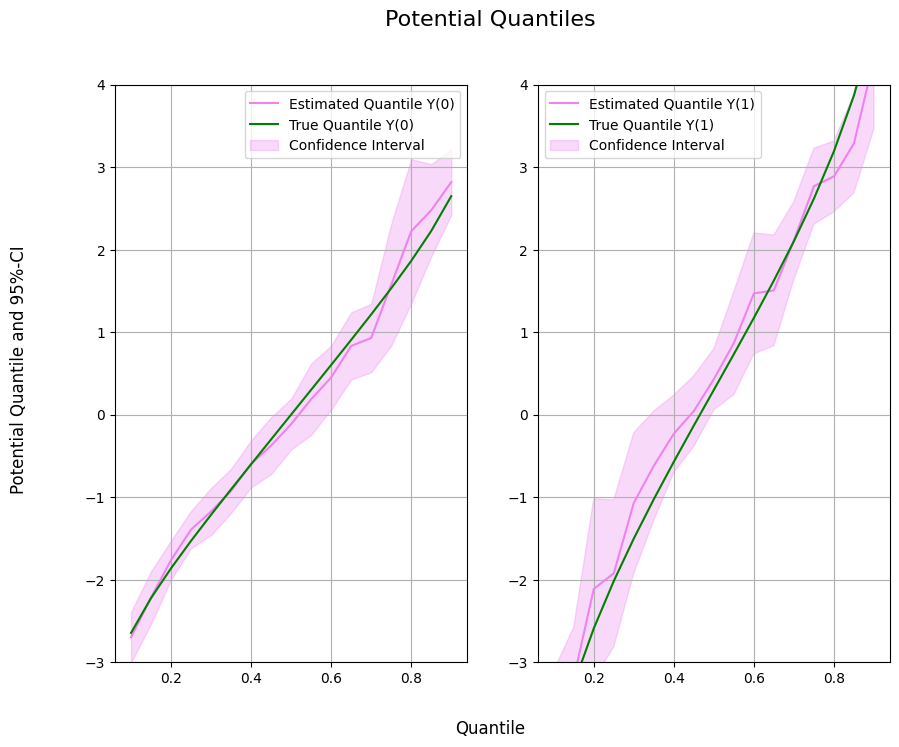

In [7]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5
fig, (ax1, ax2) = plt.subplots(1 ,2)
ax1.grid(); ax2.grid()

ax1.plot(df['Quantile'],df['DML Y(0)'], color='violet', label='Estimated Quantile Y(0)')
ax1.plot(df['Quantile'],df['Y(0)'], color='green', label='True Quantile Y(0)')
ax1.fill_between(df['Quantile'], df['DML Y(0) lower'], df['DML Y(0) upper'], color='violet', alpha=.3, label='Confidence Interval')
ax1.legend()
ax1.set_ylim(-3, 4)

ax2.plot(df['Quantile'],df['DML Y(1)'], color='violet', label='Estimated Quantile Y(1)')
ax2.plot(df['Quantile'],df['Y(1)'], color='green', label='True Quantile Y(1)')
ax2.fill_between(df['Quantile'], df['DML Y(1) lower'], df['DML Y(1) upper'], color='violet', alpha=.3, label='Confidence Interval')
ax2.legend()
ax2.set_ylim(-3, 4)

fig.suptitle('Potential Quantiles', fontsize=16)
fig.supxlabel('Quantile')
_ = fig.supylabel('Potential Quantile and 95%-CI')

## Quantile Treatment Effects (QTEs)
In most cases, we want to evaluate the quantile treatment effect as the difference between potential quantiles.
To estimate the quantile treatment effect, we can use

In [8]:
dml_QTE = dml.DoubleMLQTE(obj_dml_data,
                      ml_g, ml_m,
                      quantiles=tau_vec,
                      n_rep=1,
                      n_folds=5)
dml_QTE.fit(n_jobs_cv=n_cores-1)
QTE_est = dml_QTE.coef
print(dml_QTE)

================== DoubleMLQTE Object ==================

------------------ Fit summary       ------------------
          coef   std err         t         P>|t|     2.5 %    97.5 %
0.10 -1.308757  0.393705 -3.324208  8.867014e-04 -2.080404 -0.537109
0.15 -1.261957  0.179919 -7.014048  2.315196e-12 -1.614591 -0.909323
0.20 -0.928881  0.456698 -2.033907  4.196093e-02 -1.823992 -0.033770
0.25 -1.236766  0.838892 -1.474286  1.404047e-01 -2.880965  0.407432
0.30 -0.014151  0.630403 -0.022448  9.820906e-01 -1.249718  1.221415
0.35 -0.040090  0.557200 -0.071948  9.426431e-01 -1.132181  1.052002
0.40  0.264882  0.400061  0.662103  5.079052e-01 -0.519224  1.048987
0.45  0.329681  0.409271  0.805533  4.205124e-01 -0.472476  1.131838
0.50  0.580025  0.417670  1.388717  1.649188e-01 -0.238593  1.398644
0.55  0.637418  0.477917  1.333741  1.822889e-01 -0.299283  1.574119
0.60  0.872867  0.514723  1.695798  8.992406e-02 -0.135972  1.881706
0.65  0.873278  0.514633  1.696895  8.971645e-02 -0.135384

As for other ``dml`` objects, we can use ``.bootstrap`` and ``.confint`` to generate jointly valid confidence intervals.

In [9]:
dml_QTE.bootstrap(n_rep_boot=2000)
ci_QTE = dml_QTE.confint(level=0.95, joint=True)
ci_QTE

,2.5 %,97.5 %
0.10,-2.409189,-0.208325
0.15,-1.764842,-0.759073
0.20,-2.205382,0.347620
0.25,-3.581527,1.107994
0.30,-1.776169,1.747867
0.35,-1.597501,1.517322
0.40,-0.853316,1.383080
0.45,-0.814260,1.473623
0.50,-0.587391,1.747442
0.55,-0.698394,1.973229


As before, let us take a look at the estimated effects and confidence intervals.

In [10]:
QTE = Y1_quant - Y0_quant
data = {"Quantile": tau_vec, "QTE": QTE, "DML QTE": QTE_est,
        "DML QTE lower": ci_QTE['2.5 %'], "DML QTE upper": ci_QTE['97.5 %']}
df = pd.DataFrame(data)
print(df)

      Quantile       QTE   DML QTE  DML QTE lower  DML QTE upper
0.10      0.10 -1.490679 -1.308757      -2.409189      -0.208325
0.15      0.15 -1.044404 -1.261957      -1.764842      -0.759073
0.20      0.20 -0.728919 -0.928881      -2.205382       0.347620
0.25      0.25 -0.487102 -1.236766      -3.581527       1.107994
0.30      0.30 -0.288428 -0.014151      -1.776169       1.747867
0.35      0.35 -0.119867 -0.040090      -1.597501       1.517322
0.40      0.40  0.030407  0.264882      -0.853316       1.383080
0.45      0.45  0.168289  0.329681      -0.814260       1.473623
0.50      0.50  0.299632  0.580025      -0.587391       1.747442
0.55      0.55  0.432990  0.637418      -0.698394       1.973229
0.60      0.60  0.570831  0.872867      -0.565820       2.311553
0.65      0.65  0.720043  0.873278      -0.565156       2.311712
0.70      0.70  0.888061  1.030968      -0.419030       2.480966
0.75      0.75  1.086720  0.815253      -0.285589       1.916095
0.80      0.80  1.329007 

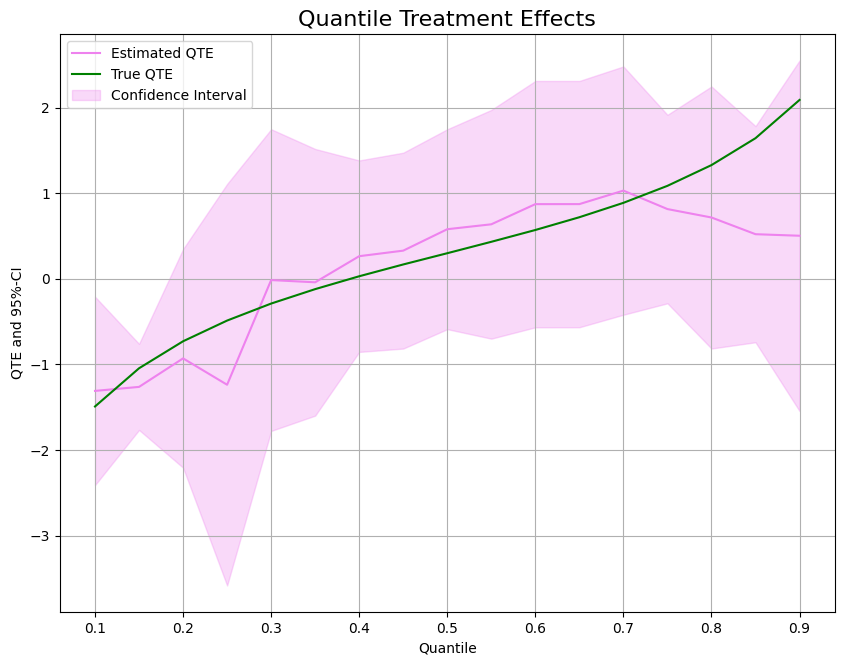

In [11]:
plt.rcParams['figure.figsize'] = 10., 7.5
fig, ax = plt.subplots()
ax.grid()

ax.plot(df['Quantile'],df['DML QTE'], color='violet', label='Estimated QTE')
ax.plot(df['Quantile'],df['QTE'], color='green', label='True QTE')
ax.fill_between(df['Quantile'], df['DML QTE lower'], df['DML QTE upper'], color='violet', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('Quantile Treatment Effects', fontsize=16)
plt.xlabel('Quantile')
_ = plt.ylabel('QTE and 95%-CI')